# HW6 TIME SERIES ANALYSIS

## Chris Prince (cmp670@nyu.edu)

*Using Dr. Bianco's workbook as a template.*

### Data

MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:

<img src="https://raw.githubusercontent.com/fedhere/PUI2015_fbianco/master/HW6/Ridetypes.png">

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

You will end up with a python numpy array of 
shape (600,23,194)

*note that the missing values are inputted as -1*

### Imports for this notebook:

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import statsmodels.api as sm
from sklearn.cluster import KMeans

In [2]:
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
font = {'size'   : 14}
legend = {'fontsize': 12}

matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)

### Task 1: 
Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
Identify it and figure out what it is due to.


### Task 2: 
Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


### Task 3:
Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


### EXTRA CREDIT: Cluster. 
Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

## Task 1

Loading the data cube:

In [4]:
mta = np.load('MTA_Fare.npy')

In [5]:
#Let's double check the shape of the cube:
mta.shape


(600, 23, 194)

Construct a vector of ride type identifiers:

In [6]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'unlim','xbus','stud'])

Construct a vector of weeks:

In [7]:
weeks = pd.date_range('05/21/2010', '02/21/2014', freq='7D')

Let's check the length of this vector:

In [8]:
len(weeks)

197

This should be 194. Fortunately, we can guess *a priori* what this mysterious event should be (Sandy, of course) so if we just create a vector of the right length, we will see if we're off when we do detect it.

In [9]:
weeks = pd.date_range('05/21/2010', periods=194, freq='7D')

In [10]:
weeks

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23', 
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='7D', tz=None)

Convert the dataframe to float so that we can replace coded missing values with NaN.

In [11]:
mta = mta.astype('float')
mta[mta==-1] = float('NaN')

We want to visualize the outliers, so let's collapse the cube on ride types. We'll need this for the next task, anyway.

In [12]:
mta_bytype = np.nansum(mta, axis = 0)

/usr/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:514: FutureWarning: In Numpy 1.9 the sum along empty slices will be zero.
  FutureWarning)


Calculate mean and sd for each type so that $3\sigma$ bounds can be created for outlier detection.

In [13]:
mean_bytype = [np.nanmean(mta_bytype[i]) for i in range(len(mta_bytype))]
sd_bytype = [np.nanstd(mta_bytype[i]) for i in range(len(mta_bytype))]

(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

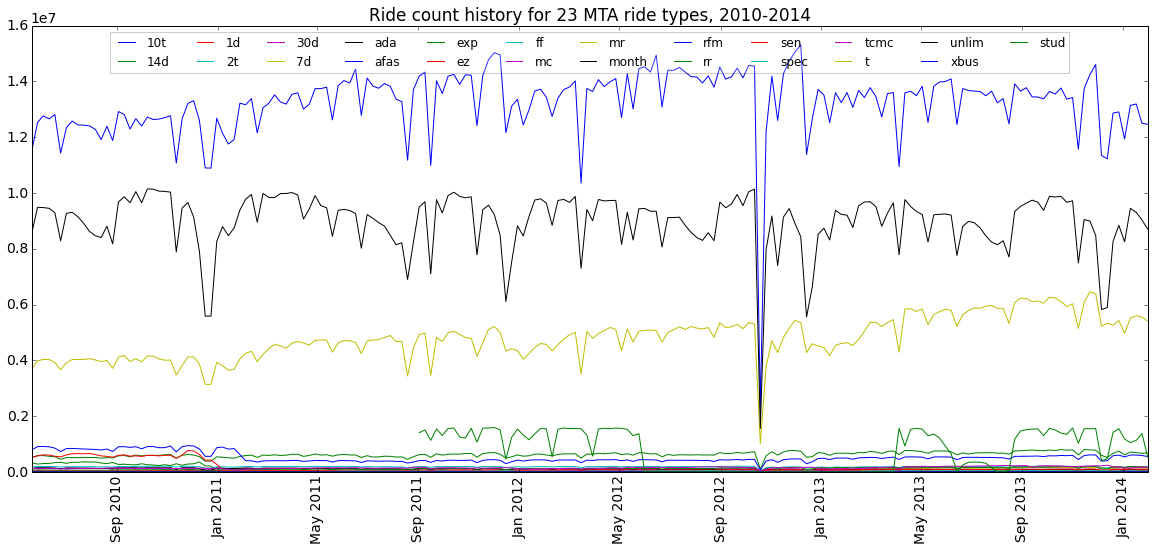

In [14]:
pl.figure(figsize=(20,8))
for i in range(len(mta_bytype)):
    plot(weeks, mta_bytype[i], label=ridetype[i])
pl.title('Ride count history for 23 MTA ride types, 2010-2014')
leg = pl.legend(ncol=12, loc='upper center')
leg.get_frame().set_alpha(0.2)
pl.xticks(rotation=90)

It's hard to see the series with lower numbers, so we'll normalize by mean:

(0, 3)

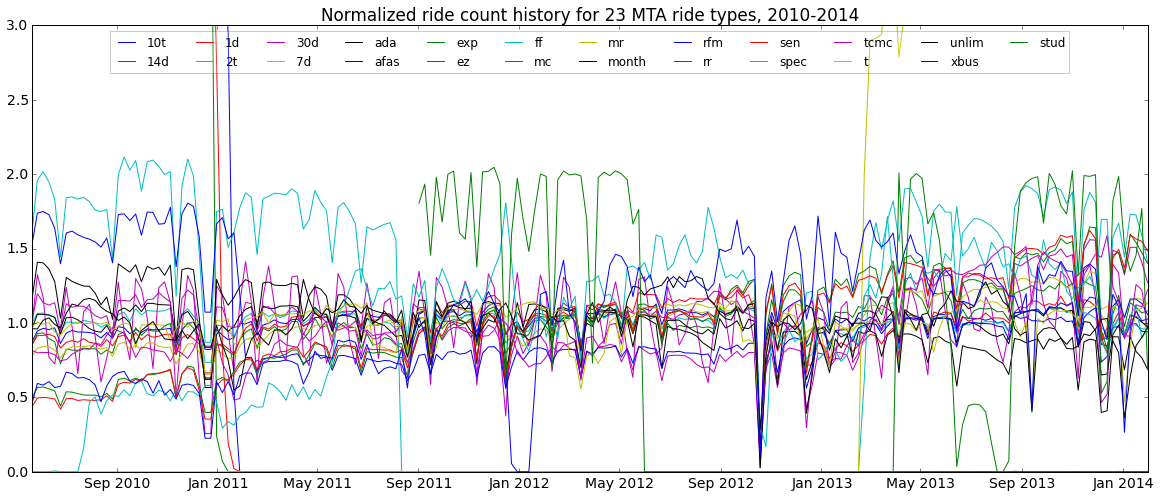

In [15]:
pl.figure(figsize=(20,8))
for i in range(len(mta_bytype)):
    plot(weeks, mta_bytype[i] /mean_bytype[i], label=ridetype[i])

pl.title('Normalized ride count history for 23 MTA ride types, 2010-2014')
leg = pl.legend(ncol=12, loc='upper center')
leg.get_frame().set_alpha(0.2)

ax = pl.gca()
ax.set_ylim([0,3])

Clearly there's an event around Sandy (October-ish 2012). Let's plot each series and identify the outliers:

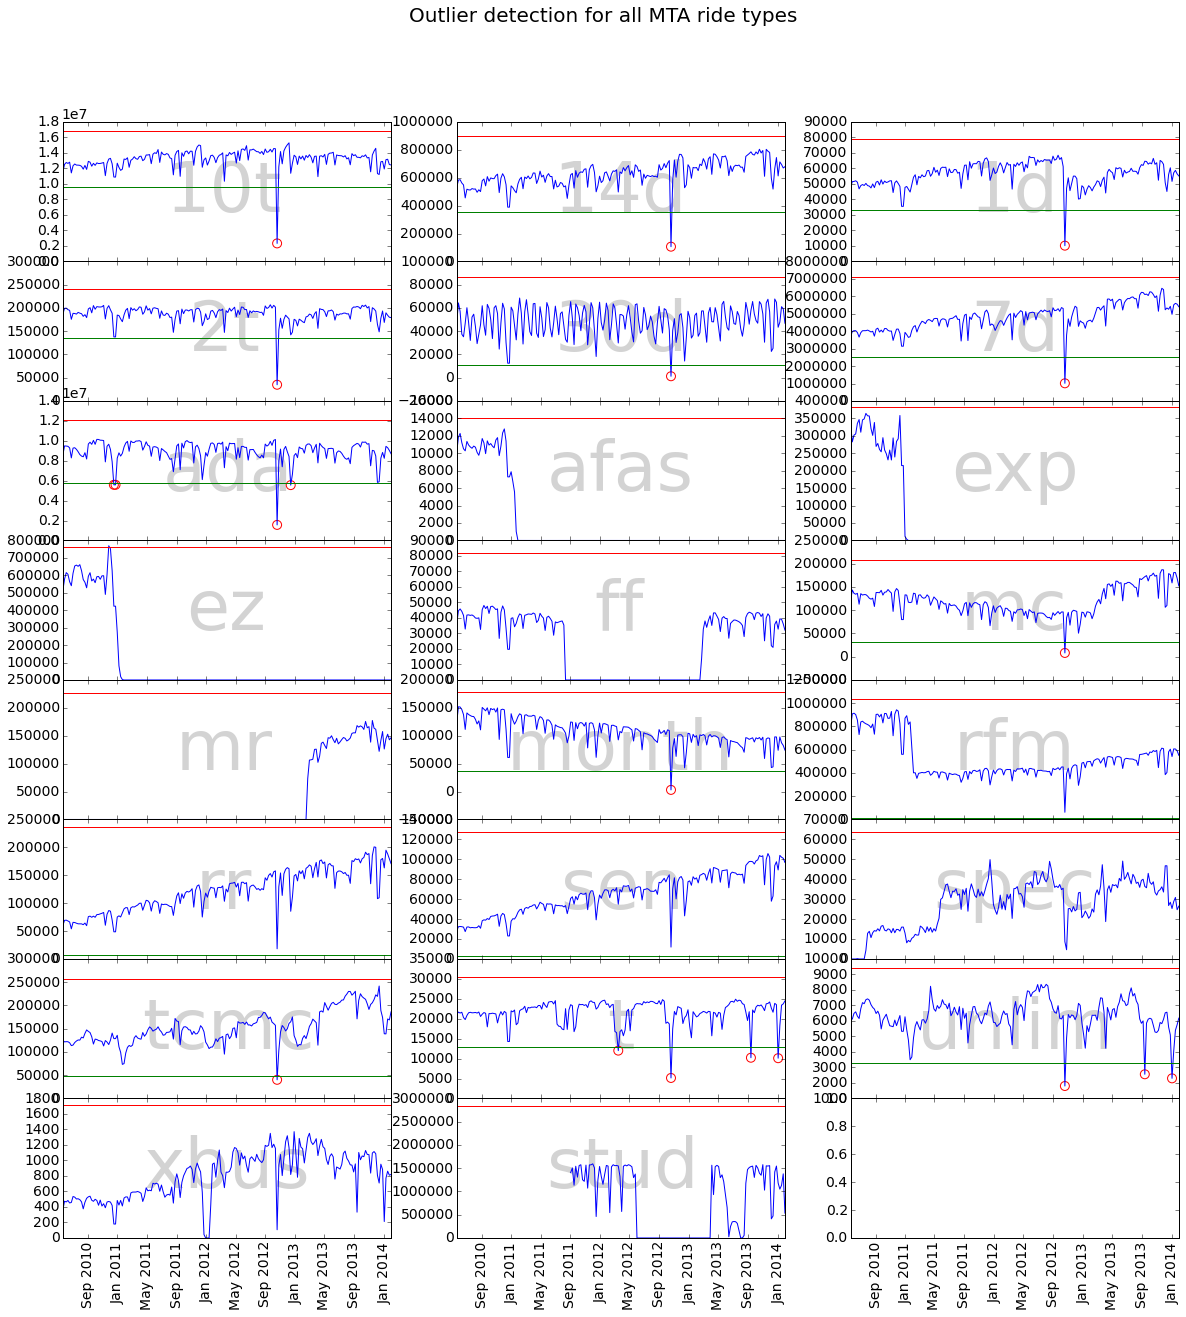

In [16]:
f, ax = pl.subplots(8,3,sharex='all', figsize=(20,20))
f.subplots_adjust(hspace=0)
alloutlierdates = []
for i in range(len(mta_bytype)):
    #calculate bounds
    ulim = mean_bytype[i] + 3*sd_bytype[i]
    llim = mean_bytype[i] - 3*sd_bytype[i]
    
    #detect outliers
    out = mta_bytype[i][mta_bytype[i] < llim]
    outloc = np.where(mta_bytype[i] < llim)
    alloutlierdates.append(outloc[0].tolist())

    #create grid of plots
    ax[i/3, i%3].text(0.5, 0.5, ridetype[i], 
                      color='lightgray', ha="center", va="center", size=70, 
                      transform=ax[i/3, i%3].transAxes, zorder=-1)
    ax[i/3, i%3].plot(weeks, mta_bytype[i], label=ridetype[i])
    ax[i/3, i%3].scatter(weeks[outloc[0]], out, s=80, facecolors='none', color='r')
    
    #we don't care about lower limits less than zero, so don't waste whitespace with it:
    ax[i/3, i%3].plot([weeks.min(), weeks.max()],
            [max(llim,0), max(llim,0)],
           label='$\\bar{x}-3s$')
    ax[i/3, i%3].plot([weeks.min(), weeks.max()],
            [ulim, ulim],
            label='$\\bar{x}+3s$')
    
    #pl.xticks only works on the very last subplot
    for tick in ax[i/3, i%3].get_xticklabels():
        tick.set_rotation(90)
    pl.xticks(rotation=90)

#Why all this white space?
f.suptitle('Outlier detection for all MTA ride types', fontsize=20)

The October 2012 point shows up in multiple series. We can identify it as the most common outlier from all detected:

In [17]:
#Thanks stackexchange!
mostoutliers=Counter(x for sublist in alloutlierdates for x in sublist).most_common(1)
mostoutliers

[(126, 12)]

In [18]:
weeks[mostoutliers[0][0]]

Timestamp('2012-10-19 00:00:00', offset='7D')

This is two weeks before Sandy struck NYC. This must be a result of the indexing problem we noticed above.

## Task 2

We first need to pick a window size for a rolling average. Let's try different sizes on the unlimited ride series:

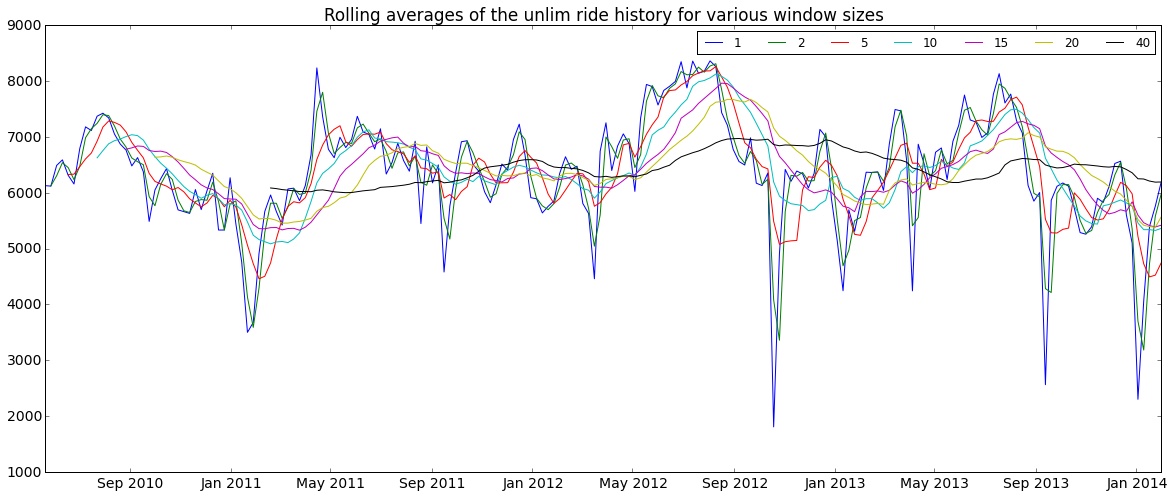

In [19]:
pl.figure(figsize=(20,8))
for i in [1,2,5,10,15,20,40]: #40 just for the hell of it
    plot(weeks, pd.rolling_mean(pd.Series(mta_bytype[20]), i), label=i)
pl.legend(ncol=7)
pl.title('Rolling averages of the unlim ride history for various window sizes')

This is somewhat subjective; we want to smooth without dropping real perturbations. Either 5 or 10 would probably work; I'll use 10 here. Let's calculate $R^2$ for linear regression and ADFuller test statistics for each type. Note the Student type ADFuller test fails (perhaps too many NaNs?), so it's handled with an exception.

TYPE	Rsq	Regr. slope	ADF stat	ADF p-val, Crit vals (5%, 10%)
10t	0.160	4155		-11.326		0.000	-2.877	-2.575
14d	0.820	1096		-2.155		0.223	-2.877	-2.575
1d	0.108	36		-2.130		0.233	-2.877	-2.575
2t	0.024	-28		-9.921		0.000	-2.877	-2.575
30d	0.048	16		-3.938		0.002	-2.877	-2.575
7d	0.794	10555		-1.515		0.526	-2.877	-2.575
ada	0.062	-2295		-9.545		0.000	-2.877	-2.575
afas	0.425	-47		-2.630		0.087	-2.878	-2.575
exp	0.401	-1207		-3.021		0.033	-2.878	-2.575
ez	0.409	-2481		-2.488		0.118	-2.878	-2.575
ff	0.023	-59		-1.495		0.536	-2.877	-2.575
mc	0.063	124		-0.595		0.872	-2.877	-2.575
mr	0.577	872		-0.258		0.931	-2.877	-2.575
month	0.873	-302		-1.469		0.549	-2.877	-2.575
rfm	0.152	-1135		-2.132		0.232	-2.877	-2.575
rr	0.968	614		-0.979		0.761	-2.877	-2.575
sen	0.962	333		-1.039		0.739	-2.877	-2.575
spec	0.580	148		-2.712		0.072	-2.877	-2.575
tcmc	0.643	464		-2.967		0.038	-2.877	-2.575
t	0.007	3		-8.145		0.000	-2.877	-2.575
unlim	-0.005	0		-6.313		0.000	-2.877	-2.575
xbus	0.699	4		-1.793		0.384	-2

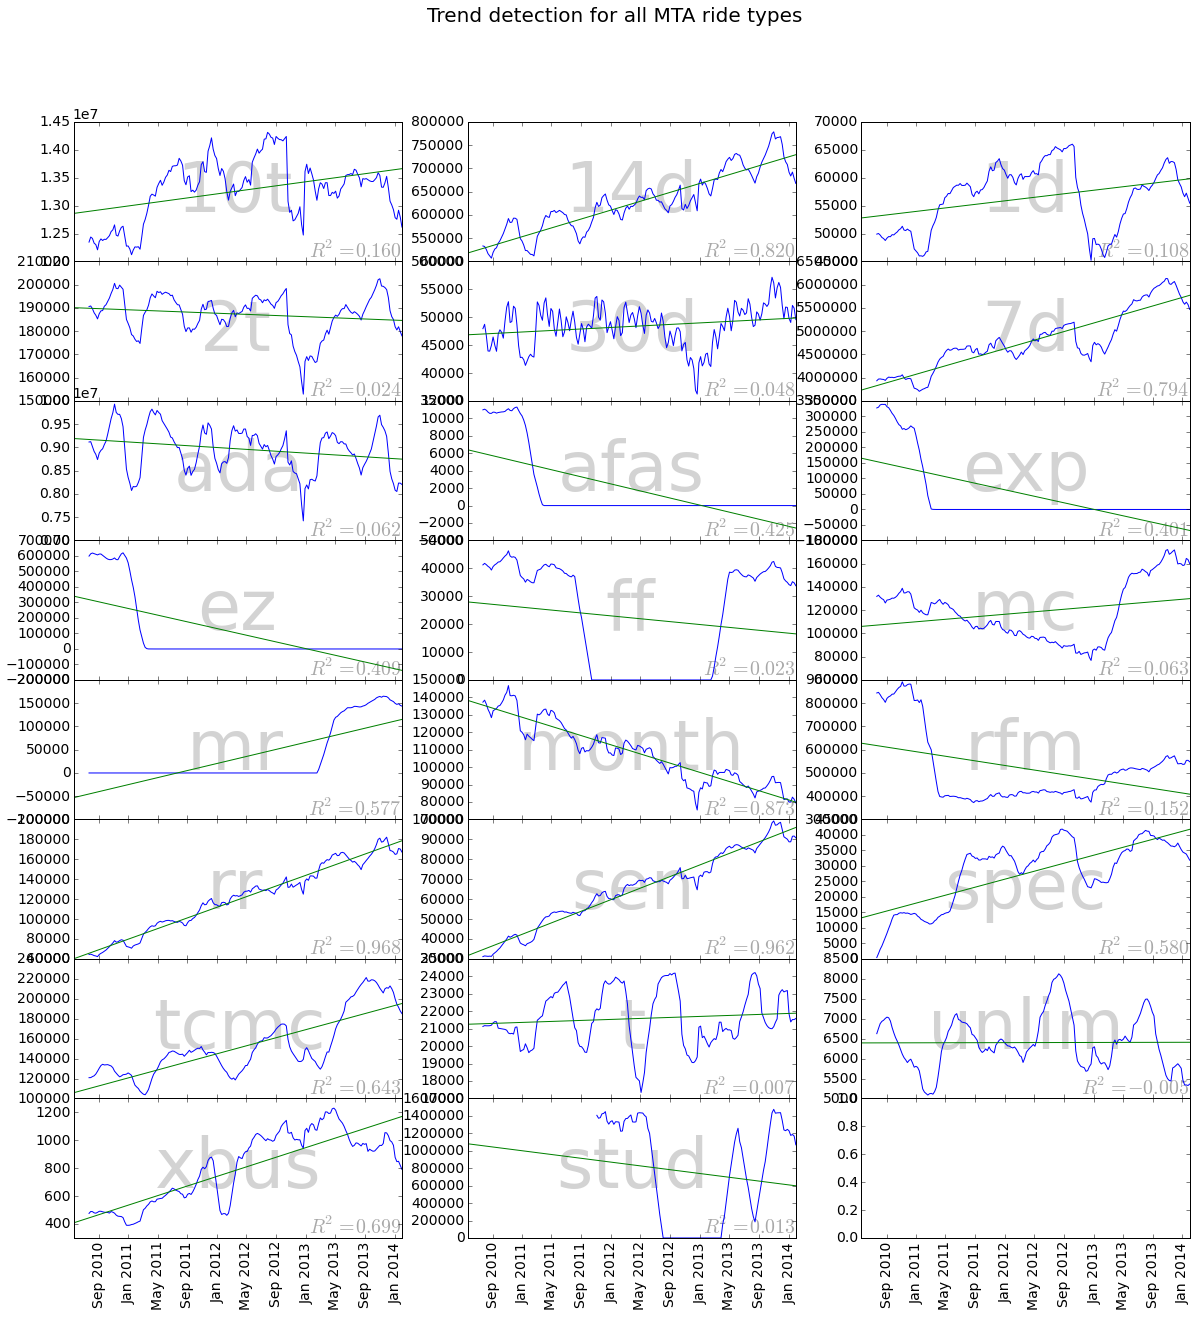

In [20]:
f, ax = pl.subplots(8,3,sharex='all', figsize=(20,20))
f.subplots_adjust(hspace=0)
print 'TYPE\tRsq\tRegr. slope\tADF stat\tADF p-val, Crit vals (5%, 10%)'
for i in range(len(mta_bytype)):
    linfit = sm.OLS(pd.rolling_mean(pd.Series(mta_bytype[i]), 10), 
                    sm.add_constant(arange(194)), 
                    missing='drop').fit()
    linfitr2 = linfit.rsquared_adj
    
    #Exception needed becuase one series ADF test fails
    try:
        adf = sm.tsa.adfuller(mta_bytype[i])
        print '%s\t%.3f\t%.0f\t\t%.3f\t\t%.3f\t%.3f\t%.3f'%(
            ridetype[i], linfitr2, linfit.params[1], adf[0], adf[1],adf[4]['5%'],adf[4]['10%'])
    except LinAlgError:
        print '%s\t%.3f\t%.0f\t\tError running ADFuller test.'%(ridetype[i], linfitr2, linfit.params[1])
    
    #Plot the rolling means and linear fits
    ax[i/3, i%3].text(1, 0, '$R^{2} = %.3f$'%linfit.rsquared_adj, 
                      color='darkgray', ha="right", va="bottom", size=20, 
                      transform=ax[i/3, i%3].transAxes, zorder=-1)
    ax[i/3, i%3].text(0.5, 0.5, ridetype[i], 
                      color='lightgray', ha="center", va="center", size=70, 
                      transform=ax[i/3, i%3].transAxes, zorder=-1)
    ax[i/3, i%3].plot(weeks, pd.rolling_mean(pd.Series(mta_bytype[i]), 10), label=ridetype[i])
    ax[i/3, i%3].plot(weeks, np.dot(linfit.params, [np.ones(194), arange(194)]))
    for tick in ax[i/3, i%3].get_xticklabels():
        tick.set_rotation(90)
    pl.xticks(rotation=90)

f.suptitle('Trend detection for all MTA ride types', fontsize=20)

Judging by the series statistics, the following are trending:


| TYPE  | Rsq   | Regr. slope | ADF stat | ADF p-val | (5% crit val) | (10% crit val)         |
|-------|-------|-------------|----------|---------------------------------------|--------|--------|
| 14d   | 0.820 | 1096        |          -2.155    | 0.223 | -2.877 | -2.575 |
| 7d    | 0.794 | 10555       |          -1.515    | 0.526 | -2.877 | -2.575 |
| month | 0.873 | -302        |          -1.469    | 0.549 | -2.877 | -2.575 |
| rr    | 0.968 | 614         |          -0.979    | 0.761 | -2.877 | -2.575 |
| sen   | 0.962 | 333         |          -1.039    | 0.739 | -2.877 | -2.575 |
| xbus  | 0.699 | 4           |          -1.793    | 0.384 | -2.877 | -2.575 |

Visually, these all seem like reasonable assessments, xbus being the least convinving (note the lower $R^2$ value and small slope of 4 additional riders per week). All of these are increasing except for the monthly, which is decreasing at an average rate ot 302 riders per week. The fastest increase is seen in the 7-day rides, with 10,500 additional rides per week. 7-days are popular with tourists, so this may reflect a healthier tourism sector in NYC over the last few years.

The following types have marginal $R^2$ or ADF statistics. The visual trends are also less convincing than those above.

| TYPE | Rsq   | Regr. slope | ADF stat | ADF p-val | (5% crit val) | (10% crit val)   |
|------|-------|-------------|----------|--------------------------------|-------|--------|--------|
| 1d   | 0.108 | 36          |          -2.130                           | 0.233 | -2.877 | -2.575 |
| afas | 0.425 | -47         |          -2.630                           | 0.087 | -2.878 | -2.575 |
| spec | 0.580 | 148         |          -2.712                           | 0.072 | -2.877 | -2.575 |
| tcmc | 0.643 | 464         |          -2.967                           | 0.038 | -2.877 | -2.575 |

## Task 3

Reclaim memory and collapse on stations:

In [21]:
%xdel mta_bytype

In [22]:
mta_bystation = np.nansum(mta, axis = 1)

What is the nearest frequency corresponding to a period of 52 weeks? Element [4].

In [23]:
1/np.fft.rfftfreq(194, 1.0)[3:6]

array([ 64.66666667,  48.5       ,  38.8       ])

Plot all FFTs and collect power at 48.5 week points. We peek at the results and choose a color threshold for illustration purposes.

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


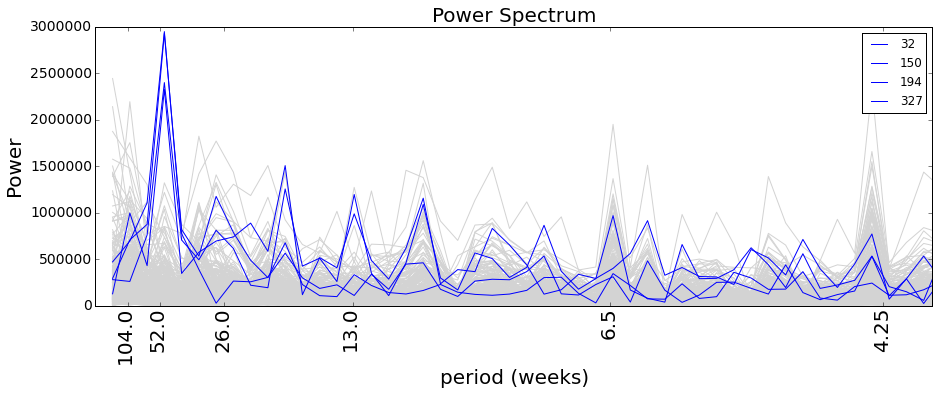

In [24]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
f48=[]

for i in range(600):
    f = np.abs(np.fft.rfft(mta_bystation[i]))
    f48.append(f[4])
    if f[4] > 2000000:
        fcolor = 'blue'
        fz = 1000
        flabel = '%s'%i
    else:
        fcolor = 'lightgray'
        fz = -1
        flabel = None
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-', color = fcolor, zorder = fz, label = flabel)
    ax.set_xlim(0,0.25)
    ax.set_xticks([1/104., 1/52., 1/26., 1/13., 1/6.5, 1/4.25])
    ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
    pl.xlabel("period (weeks)", fontsize=20)
    pl.ylabel("Power", fontsize=20)
    pl.title("Power Spectrum", fontsize=20)
    pl.xticks(rotation=90)
    pl.legend()

Use our f48 list to identify the series associated with strongest 52-week cycles.

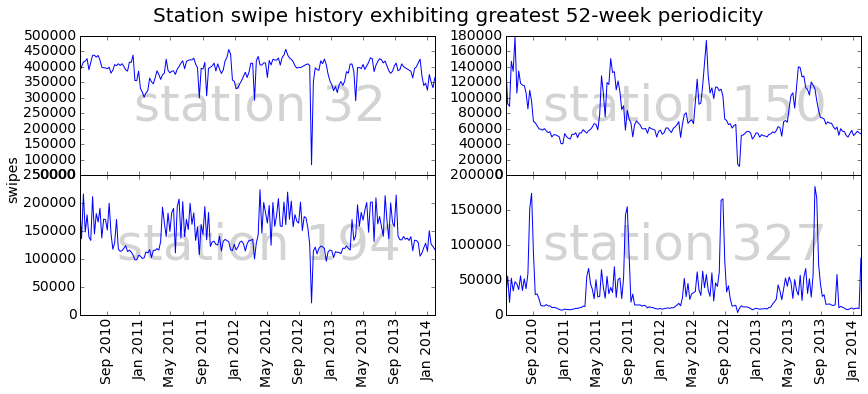

In [25]:
f, ax = pl.subplots(2,2,sharex='all', figsize=(14,5))
f.subplots_adjust(hspace=0)
for i, station in enumerate(list(np.where(np.asarray(f48) > 2000000)[0])):
    ax[i/2, i%2].plot(weeks, mta_bystation[station], label='Station %i'%station)
    ax[i/2, i%2].text(0.5, 0.5, 'station %i'%station, 
                      color='lightgray', ha="center", va="center", size=50, 
                      transform=ax[i/2, i%2].transAxes, zorder=-1)
    for tick in ax[i/2, i%2].get_xticklabels():
        tick.set_rotation(90)
#f.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
f.text(0.06, 0.5, 'swipes', ha='center', va='center', rotation='vertical')
f.suptitle('Station swipe history exhibiting greatest 52-week periodicity', size=20)

32 doesn't look convincing, but the others do. Let's see what their autocorrelations are:

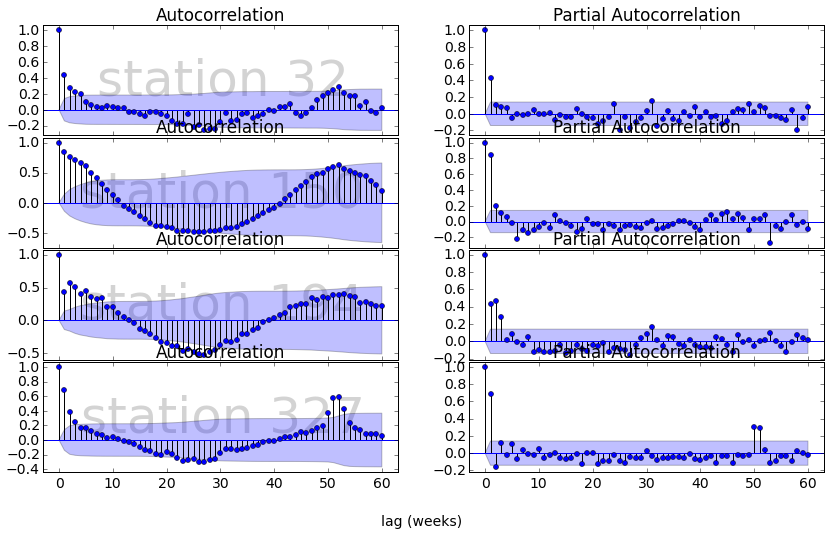

In [26]:
f, ax = pl.subplots(4,2,sharex='all', figsize=(14,8))
f.subplots_adjust(hspace=0.02)
for i, station in enumerate(list(np.where(np.asarray(f48) > 2000000)[0])):
    
    sm.graphics.tsa.plot_acf(mta_bystation[station], lags=60, ax=ax[i, 0])
    sm.graphics.tsa.plot_pacf(mta_bystation[station], lags=60, ax=ax[i, 1])
    ax[i, 0].text(0.5, 0.5, 'station %i'%station, 
                      color='lightgray', ha="center", va="center", size=50, 
                      transform=ax[i, 0].transAxes, zorder=-1)
f.text(0.5, 0.04, 'lag (weeks)', ha='center', va='center')

The strongest autocorrelation is associated with the 327th station. The 150th station has negative autocorrelation. This may be because of the high frequency signal in each cycle. Stations 32 and 194 indicate the 52 week lag autocorrelation on the edge of significance, but visually we can appreciate the periodicity.

## Extra Credit

Let's do exactly what is suggested above to get a feel for how this works.

In [27]:
%xdel mta_bystation

In [28]:
tots = mta.transpose(2,0,1).reshape(mta.shape[2], mta.shape[1]*mta.shape[0]).T
tots = tots[tots.std(1)>0]

km = KMeans(n_clusters=10)

# standardize the lightcurves before clustering 

vals = ((tots.T - tots.mean(1))/tots.std(1)).T

mycluster = km.fit(vals)

We now plot the time series. `cm.hsv` takes a value from 0 to 1, so we divide the K-Means label by 10 and pass that value.

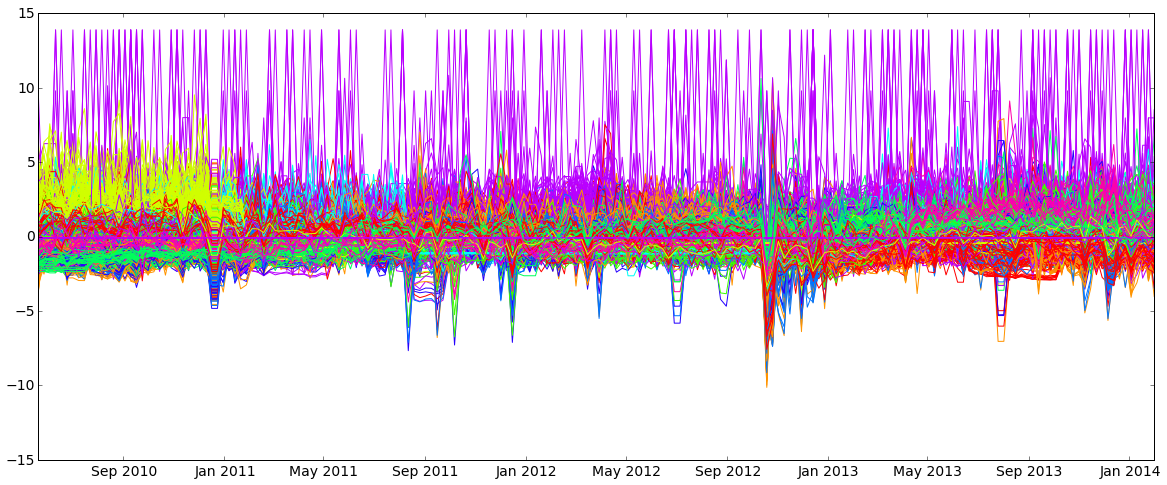

In [29]:
pl.figure(figsize=(20,8))
for i in range(len(vals)):
    plot(weeks, vals[i], c = cm.hsv(mycluster.labels_[i]/10.))

Well that's a mess. Let's separate them so we can see the differences. Some clusters aren't so different, but there are definitely some types that stand apart.

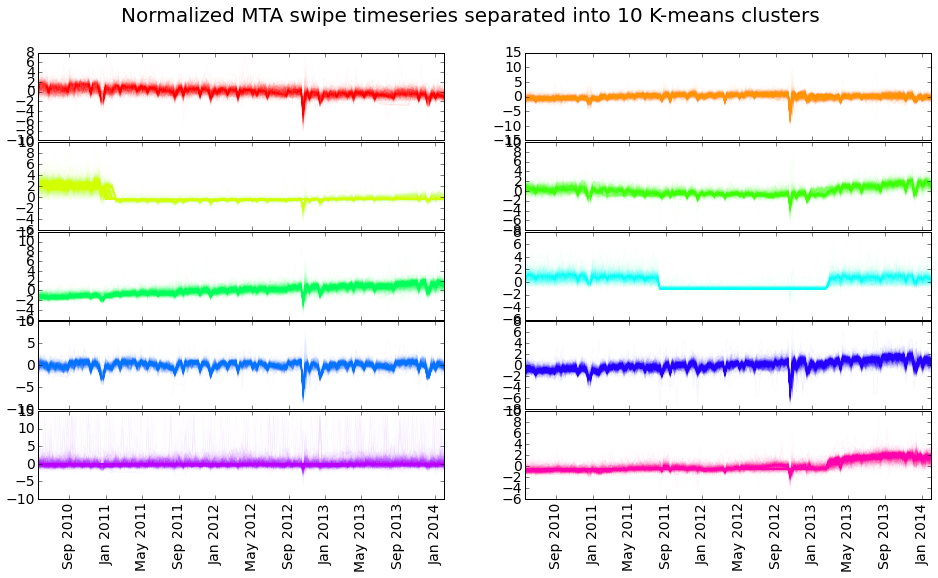

In [30]:
f, ax = pl.subplots(5,2,sharex='all', figsize=(16,8))
f.subplots_adjust(hspace=0.02)

for i in range(len(vals)):
    lab = mycluster.labels_[i]
    ax[lab/2, lab%2].plot(weeks, vals[i], c = cm.hsv(lab/10.), alpha = 0.02)
for lab in range(10):
    for tick in ax[lab/2, lab%2].get_xticklabels():
        tick.set_rotation(90)
f.suptitle('Normalized MTA swipe timeseries separated into 10 K-means clusters', size=20)